***Anurag Sharma (24AI91R01)***

In [44]:
# Standard Library Imports
import math
import string
from collections import defaultdict

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# NLP Libraries
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

# Data Science and Visualization Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Question 1: (1 Marks)

Load the 20Newsgroups datasets (both train and test splits) from scikit-learn. You are not allowed to load any other version of this dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [46]:
train_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), random_state=42)
test_data = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), random_state=42)

In [47]:
print(len(train_data.data))
print(len(test_data.data))

11314
7532


In [48]:
new_train_size = len(train_data.data)
new_test_size = len(test_data.data)

In [49]:
train_data_subset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), random_state=42, shuffle=True)
test_data_subset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), random_state=42, shuffle=True)

train_data = {
    'data': train_data_subset.data[:new_train_size],
    'target': train_data_subset.target[:new_train_size]
}
test_data = {
    'data': test_data_subset.data[:new_test_size],
    'target': test_data_subset.target[:new_test_size]
}
print(len(train_data['data']))
print(len(test_data['data']))

11314
7532


Question 2: (2 Mark)

Preprocess the text data using nltk library to perform the following:

1. Removing stopwords
2. Removing punctuations
3. Tokenization
4. Convert each word to id format.
5. The maximum sequence length for each samples is 150.
6. For efficient mini-batching make sure, all samples follow the same length by either padding or chopping the sequence.

Finally, partition the train set into 85%-15% train-val split.

In [50]:
import en_core_web_sm
use_tk = en_core_web_sm.load()

In [51]:
def text_process(txt):
    txt = txt.lower()
    texts = use_tk(txt)
    token_list = []
    for token in texts:
        if not (token.is_space or token.is_stop or token.is_punct):
            token_list.append(token.text)
    return token_list

In [52]:
train_tk, test_tk = [], []
for i in range(len(train_data['data'])):
    train_tk.append(text_process(train_data['data'][i]))
for i in range(len(test_data['data'])):
    test_tk.append(text_process(test_data['data'][i]))

In [53]:
# from itertools import chain
# word_mappings = {'<PAD>': 0, '<UNK>': 1}
# word_mappings.update(enumerate(set(chain.from_iterable(train_tk)), start=2))

In [54]:
word_mappings = {'<PAD>': 0, '<UNK>': 1}
for tokens in train_tk:
    for token in tokens:
        if token not in word_mappings:
            word_mappings[token] = len(word_mappings)

In [55]:
MAX_LEN = 150

def tokens_ids(tokens, word_mappings, max_len=MAX_LEN):
    ids = [word_mappings.get(token, word_mappings['<UNK>']) for token in tokens]
    if len(ids) < max_len:
        ids += [word_mappings['<PAD>']] * (max_len - len(ids))  # Padding
    else:
        ids = ids[:max_len]  # Truncation
    return ids

In [56]:
# import numpy as np
# MAX_LEN = 150

# def tokens_ids(tokens, word_mappings, max_len=MAX_LEN):
#     unk_id = word_mappings['<UNK>']
#     pad_id = word_mappings['<PAD>']
#     ids = np.array([word_mappings.get(token, unk_id) for token in tokens[:max_len]])
#     return np.pad(ids, (0, max_len - len(ids)), mode='constant', constant_values=pad_id)

In [57]:
X_train = [tokens_ids(tokens, word_mappings) for tokens in train_tk]
X_test = [tokens_ids(tokens, word_mappings) for tokens in test_tk]

In [58]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [59]:
print(len(X_train),len(X_test))

11314 7532


In [60]:
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(train_data['target'], dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(test_data['target'], dtype=torch.long)

In [61]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.15, random_state=42, stratify=y_train_tensor)

In [62]:
print(len(X_train_tensor),len(X_val_tensor),len(y_train_tensor),len(y_val_tensor))
print(len(X_test_tensor),len(y_test_tensor))

9616 1698 9616 1698
7532 7532


Question 3: (1 Marks)

Show the class distribution

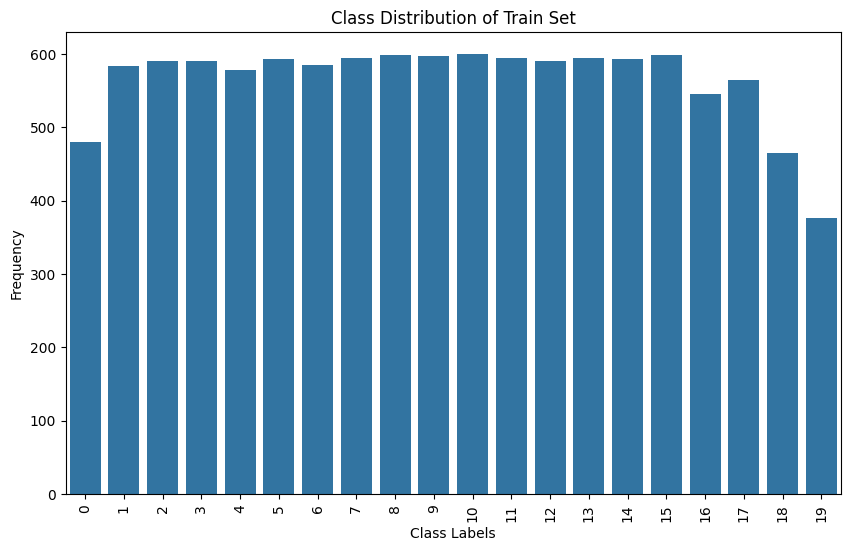

In [63]:
train_targets = train_data['target']

# Use seaborn to create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x=train_targets)
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution of Train Set")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

Question 4: (6 Marks)

Design the Encoder of the transformer model from scratch using PyTorch (i.e. using torch functions and torch layers) to perform classification on this dataset. You are not allowed to use the pytorch multi head attention layer.
Use the following hyper-parameters:
<li>d_model = 32</li>
<li>num_heads = 4</li>
<li>num_enc_layers = 4</li>
<li>d_ff = 128</li>
<li>dropout = 0.1</li>

**Note:** The output from the encoder needs to be max-pooled and then passed to the classifier

In [64]:
# Hyperparameters
d_model = 32
num_heads = 4
num_enc_layers = 4
d_ff = 128
dropout = 0.1
vocab_size = len(word_mappings)
num_classes = len(train_data['target'])
max_len = 150

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, device='cpu'):
        super().__init__()
        # Pre-compute positional encodings once
        position = torch.arange(max_len, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(1, max_len, d_model, device=device)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Use slice instead of full tensor creation
        return x + self.pe[:, :x.size(1)]

# Scaled Dot-Product Attention
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)
    # Use torch.matmul for better handling of 2D and 3D tensors
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Use torch.softmax with dim=-1 for better numerical stability
    attn = torch.softmax(scores, dim=-1)
    # Use torch.matmul to handle both 2D and 3D tensors
    return torch.matmul(attn, V), attn

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        # Combine Q, K, V projections into single linear layer
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Single projection for Q, K, V
        qkv = self.qkv_proj(x)
        q, k, v = qkv.chunk(3, dim=-1)

        # Efficient reshaping , adding an extra dimension to handle batch size of 1
        q = q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # If batch_size is 1, add an extra dimension
        if q.dim() == 3:
            q = q.unsqueeze(0)
            k = k.unsqueeze(0)
            v = v.unsqueeze(0)

        attn_output, _ = scaled_dot_product_attention(q, k, v)

        # If batch_size was 1, remove the extra dimension
        if attn_output.dim() == 4 and attn_output.shape[0] == 1:
            attn_output = attn_output.squeeze(0)

        # reshaping
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, seq_len, -1)
        return self.out_proj(attn_output)

# Feedforward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        # Use Sequential for better memory management
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(inplace=True),  # inplace=True saves memory
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.ffn(x)

# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-5)  # Added eps for stability
        self.norm2 = nn.LayerNorm(d_model, eps=1e-5)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Residual connections with pre-norm architecture
        attn_output = self.mha(self.norm1(x))
        x = x + self.dropout(attn_output)
        ffn_output = self.ffn(self.norm2(x))
        return x + self.dropout(ffn_output)

# Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_enc_layers,
                 d_ff, num_classes, max_len=150, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, device)
        self.encoder = nn.Sequential(*[
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_enc_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)
        self.device = device

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.encoder(x)
        # More efficient pooling using mean instead of max
        x = torch.mean(x, dim=1)
        return self.classifier(self.dropout(x))

Question 6: (2 Marks)

Train the model using a suitable loss function and the AdamW optimizer with the following hyper-parameters
<li>num_epochs = 100</li>
<li>batch_size = 256/128</li>
<li>lr=0.0003</li>
Save the model having the lowest validation loss.

In [65]:
# Hyperparameters
num_epochs = 100
batch_size = 128  # Can increase to 256 if memory allows
lr = 0.0003
patience = 10  # For early stopping
min_lr = 1e-6  # Minimum learning rate

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare DataLoaders with pin_memory for faster data transfer
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

Using device: cuda


In [66]:
model = TransformerClassifier(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_enc_layers=num_enc_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_len=max_len,
    dropout=dropout,
    device=device
).to(device)

In [67]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

In [69]:
# Parameters for early stopping and learning rate scheduler
early_stopping_patience = 5  # Number of epochs to wait for improvement
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, min_lr=min_lr, verbose=True)

best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0  # Counter for early stopping

# Lists to store loss values for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Store the losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Check if the validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0  # Reset the counter
        print(f"Saving best model with validation loss: {best_val_loss:.4f}")
        torch.save(best_model_state, 'best_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation loss for {epochs_without_improvement} epochs.")

    # Early stopping condition
    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {early_stopping_patience} epochs without improvement.")
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 7.1200, Val Loss: 4.0457
Saving best model with validation loss: 4.0457
Epoch 2/100, Train Loss: 3.6848, Val Loss: 3.0517
Saving best model with validation loss: 3.0517
Epoch 3/100, Train Loss: 3.3553, Val Loss: 3.0370
Saving best model with validation loss: 3.0370
Epoch 4/100, Train Loss: 3.2749, Val Loss: 2.9984
Saving best model with validation loss: 2.9984
Epoch 5/100, Train Loss: 3.1975, Val Loss: 2.9905
Saving best model with validation loss: 2.9905
Epoch 6/100, Train Loss: 3.1618, Val Loss: 2.9723
Saving best model with validation loss: 2.9723
Epoch 7/100, Train Loss: 3.1247, Val Loss: 2.9495
Saving best model with validation loss: 2.9495
Epoch 8/100, Train Loss: 3.0514, Val Loss: 2.8875
Saving best model with validation loss: 2.8875
Epoch 9/100, Train Loss: 2.9452, Val Loss: 2.7865
Saving best model with validation loss: 2.7865
Epoch 10/100, Train Loss: 2.7720, Val Loss: 2.6485
Saving best model with validation loss: 2.6485
Epoch 11/100, Train Loss: 2.5

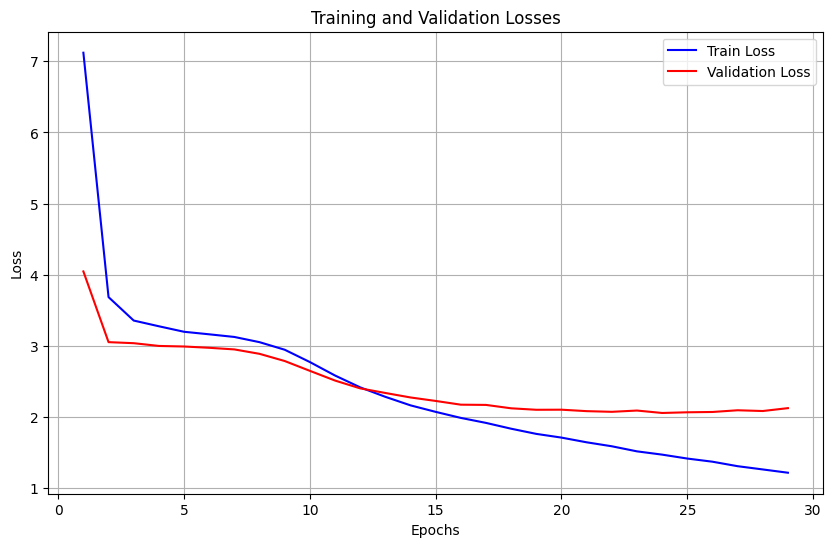

In [70]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='b')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

Question 7: (1 Marks)

Perform prediction on the train, validation and test sets. Plot the train and validation losses. Report the accuracy, precision and confusion matrix on all three dataset partitions.

Evaluation on Train Set:
Accuracy: 0.5911
Precision: 0.5883


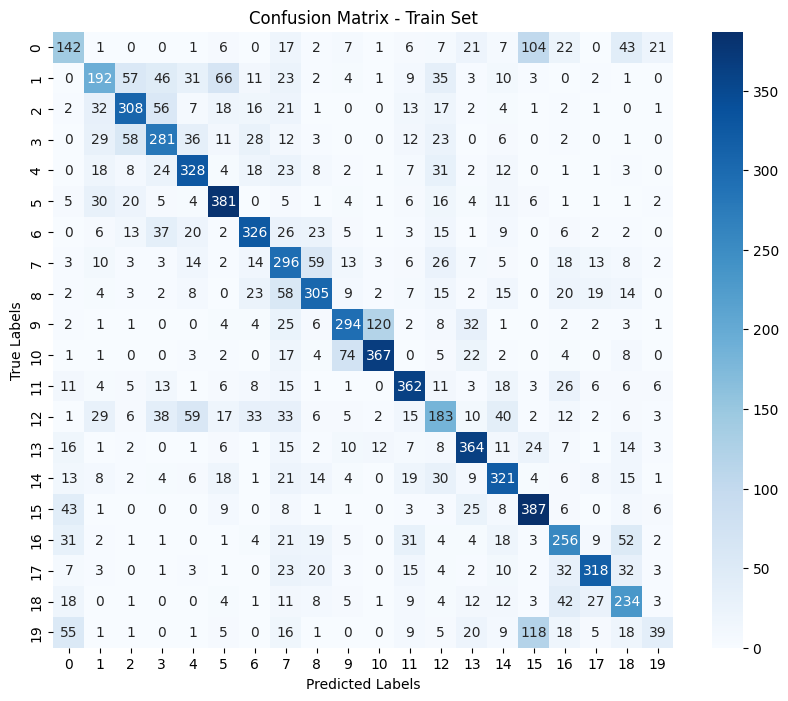

Evaluation on Validation Set:
Accuracy: 0.4211
Precision: 0.4222


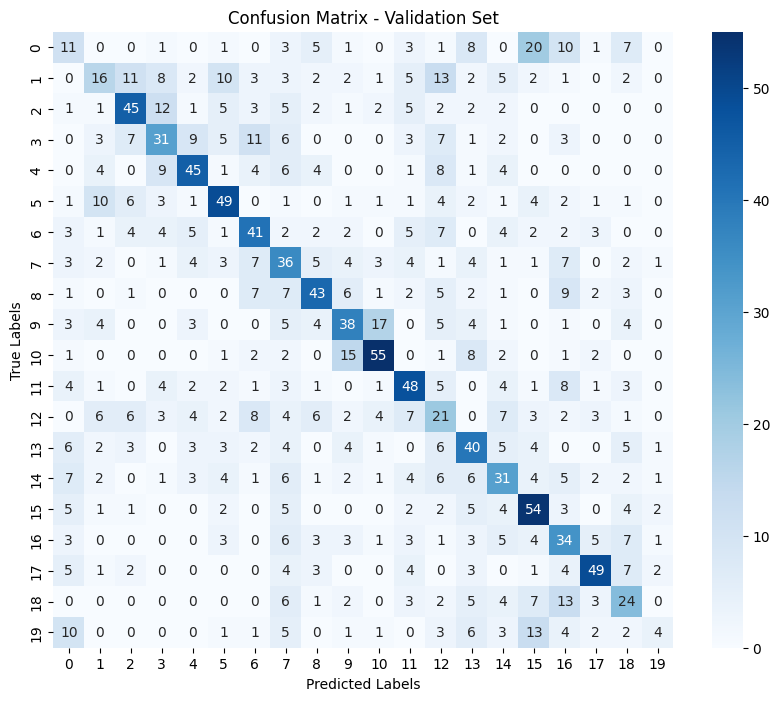

Evaluation on Test Set:
Accuracy: 0.3864
Precision: 0.3832


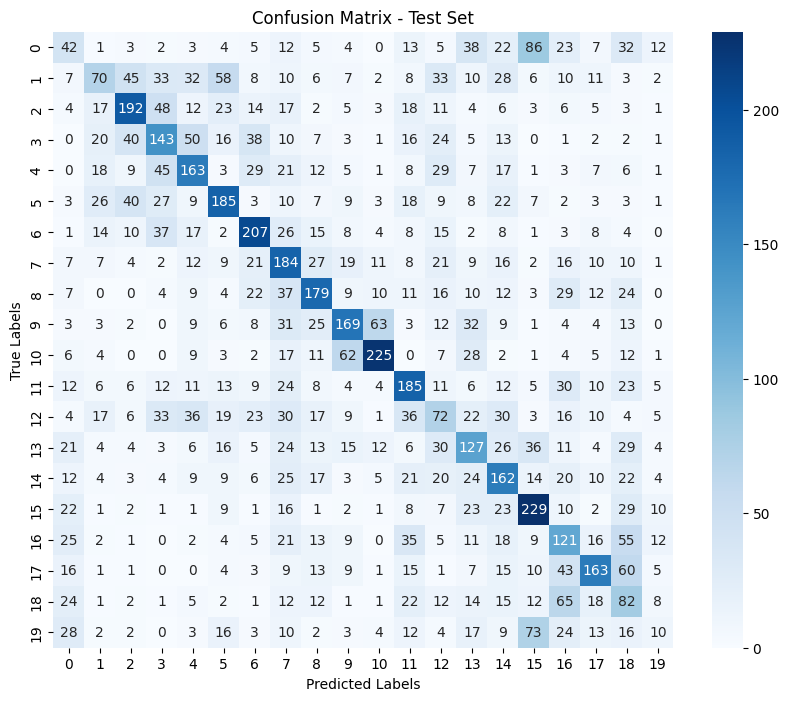

(0.3863515666489644,
 0.3832153688619395,
 array([[ 42,   1,   3,   2,   3,   4,   5,  12,   5,   4,   0,  13,   5,
          38,  22,  86,  23,   7,  32,  12],
        [  7,  70,  45,  33,  32,  58,   8,  10,   6,   7,   2,   8,  33,
          10,  28,   6,  10,  11,   3,   2],
        [  4,  17, 192,  48,  12,  23,  14,  17,   2,   5,   3,  18,  11,
           4,   6,   3,   6,   5,   3,   1],
        [  0,  20,  40, 143,  50,  16,  38,  10,   7,   3,   1,  16,  24,
           5,  13,   0,   1,   2,   2,   1],
        [  0,  18,   9,  45, 163,   3,  29,  21,  12,   5,   1,   8,  29,
           7,  17,   1,   3,   7,   6,   1],
        [  3,  26,  40,  27,   9, 185,   3,  10,   7,   9,   3,  18,   9,
           8,  22,   7,   2,   3,   3,   1],
        [  1,  14,  10,  37,  17,   2, 207,  26,  15,   8,   4,   8,  15,
           2,   8,   1,   3,   8,   4,   0],
        [  7,   7,   4,   2,  12,   9,  21, 184,  27,  19,  11,   8,  21,
           9,  16,   2,  16,  10,  10,   1],
      

In [71]:
# Load the best model
best_model = TransformerClassifier(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_enc_layers=num_enc_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_len=max_len,
    dropout=dropout,
    device=device
).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Function to predict and evaluate
def predict_and_evaluate(model, dataloader, dataset_name):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted') # Use weighted average for multi-class
    cm = confusion_matrix(y_true, y_pred)

    print(f"Evaluation on {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return accuracy, precision, cm


# Create DataLoaders for train, validation, and test sets
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


# Predictions and evaluation for each dataset
predict_and_evaluate(best_model, train_loader, "Train Set")
predict_and_evaluate(best_model, val_loader, "Validation Set")
predict_and_evaluate(best_model, test_loader, "Test Set")

Question 8: (3 Mark)

Redesign the encoder model using nn.MultiHeadAttention() layers and train it using the same cost function and optimizer. Plot the train and validation losses. Report the accuracy, precision and confusion matrix on all three dataset partitions.

Use the same hyper-parameters.

In [72]:
class TransformerClassifierMultiHead(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_enc_layers,
                 d_ff, num_classes, max_len=150, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=d_ff, dropout=dropout, batch_first=True) # Define the encoder layer
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_enc_layers) # Use the encoder layer to create the transformer encoder
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)
        self.device = device

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)
        return self.classifier(self.dropout(x))

# Instantiate the new model
multihead_model = TransformerClassifierMultiHead(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_enc_layers=num_enc_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_len=max_len,
    dropout=dropout,
    device=device
).to(device)

In [73]:
# Initialize optimizer and scheduler for the multihead model
optimizer_multihead = AdamW(multihead_model.parameters(), lr=lr, weight_decay=1e-2)
scheduler_multihead = ReduceLROnPlateau(optimizer_multihead, 'min', patience=patience, min_lr=min_lr, verbose=True)

best_val_loss_multihead = float('inf')
best_model_state_multihead = None
epochs_without_improvement_multihead = 0

train_losses_multihead = []
val_losses_multihead = []

for epoch in range(num_epochs):
    multihead_model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer_multihead.zero_grad()
        outputs = multihead_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_multihead.step()
        train_loss += loss.item()

    multihead_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = multihead_model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses_multihead.append(avg_train_loss)
    val_losses_multihead.append(avg_val_loss)

    scheduler_multihead.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss_multihead:
        best_val_loss_multihead = avg_val_loss
        best_model_state_multihead = multihead_model.state_dict()
        epochs_without_improvement_multihead = 0
        print(f"Saving best multihead model with validation loss: {best_val_loss_multihead:.4f}")
        torch.save(best_model_state_multihead, 'best_multihead_model.pth')
    else:
        epochs_without_improvement_multihead += 1
        print(f"No improvement in validation loss for {epochs_without_improvement_multihead} epochs.")

    if epochs_without_improvement_multihead >= early_stopping_patience:
        print(f"Early stopping triggered after {early_stopping_patience} epochs without improvement.")
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 8.5870, Val Loss: 7.6869
Saving best multihead model with validation loss: 7.6869
Epoch 2/100, Train Loss: 6.8636, Val Loss: 5.8838
Saving best multihead model with validation loss: 5.8838
Epoch 3/100, Train Loss: 5.1250, Val Loss: 4.2836
Saving best multihead model with validation loss: 4.2836
Epoch 4/100, Train Loss: 3.8948, Val Loss: 3.4818
Saving best multihead model with validation loss: 3.4818
Epoch 5/100, Train Loss: 3.3875, Val Loss: 3.2050
Saving best multihead model with validation loss: 3.2050
Epoch 6/100, Train Loss: 3.2004, Val Loss: 3.1007
Saving best multihead model with validation loss: 3.1007
Epoch 7/100, Train Loss: 3.1272, Val Loss: 3.0522
Saving best multihead model with validation loss: 3.0522
Epoch 8/100, Train Loss: 3.0816, Val Loss: 3.0203
Saving best multihead model with validation loss: 3.0203
Epoch 9/100, Train Loss: 3.0397, Val Loss: 2.9704
Saving best multihead model with validation loss: 2.9704
Epoch 10/100, Train Loss: 2.9704, Val

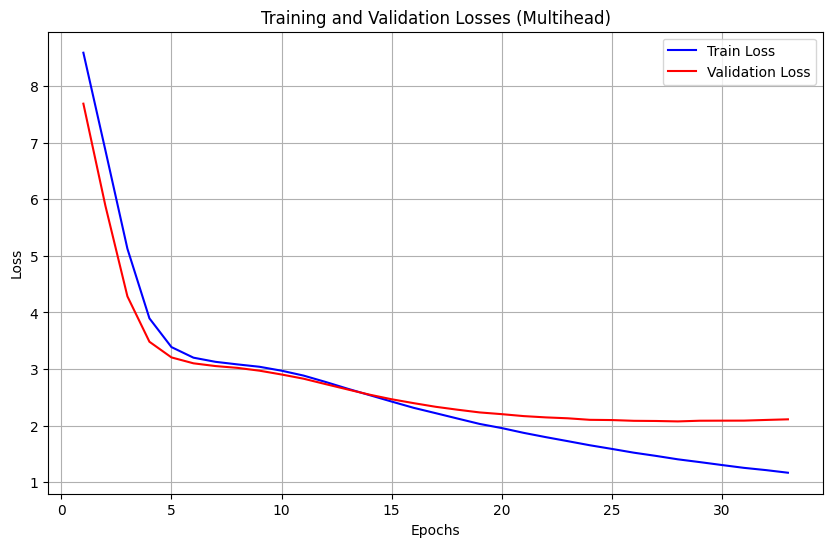

In [76]:
# Plotting training and validation losses for the multihead model
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_multihead) + 1), train_losses_multihead, label="Train Loss", color='b')
plt.plot(range(1, len(val_losses_multihead) + 1), val_losses_multihead, label="Validation Loss", color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (Multihead)')
plt.legend()
plt.grid(True)
plt.show()

Evaluation on Train Set (Multihead):
Accuracy: 0.6069
Precision: 0.6167


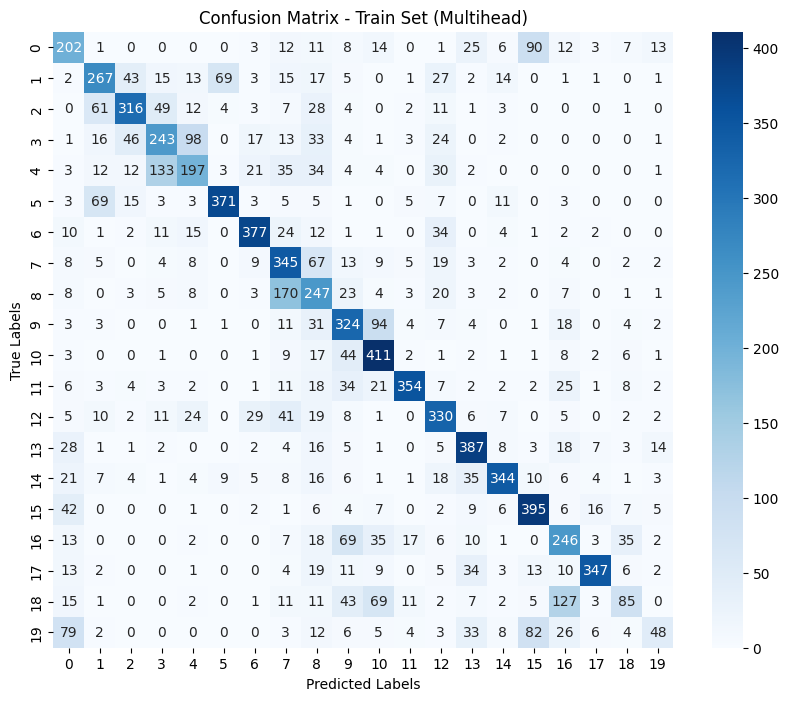

Evaluation on Validation Set (Multihead):
Accuracy: 0.4081
Precision: 0.4064


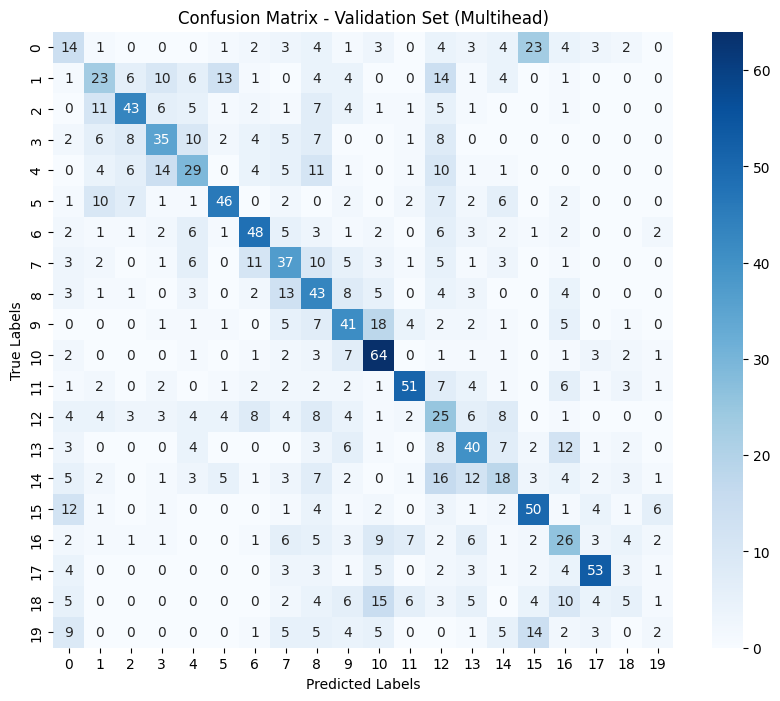

Evaluation on Test Set (Multihead):
Accuracy: 0.3614
Precision: 0.3771


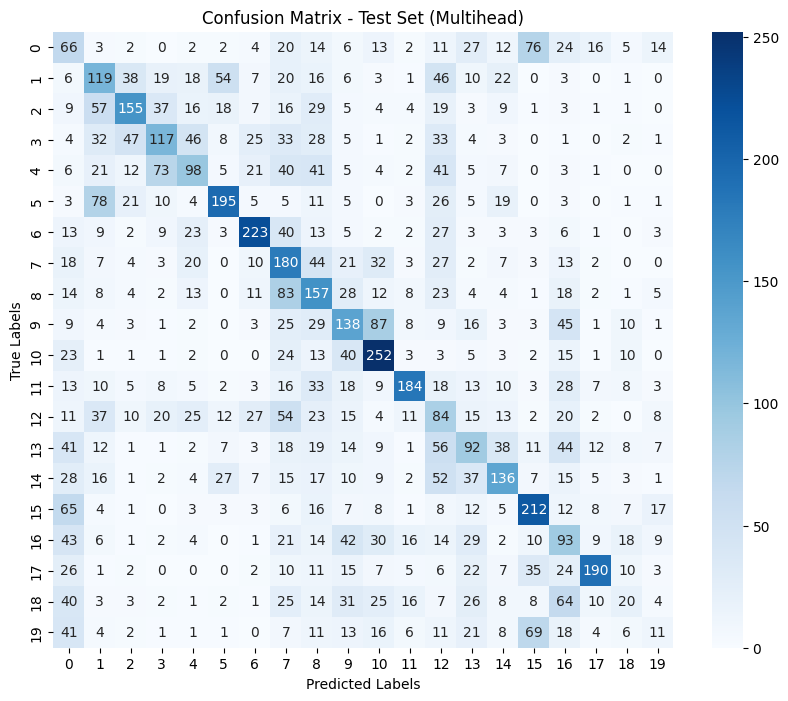

(0.36139139670738185,
 0.3771087467051971,
 array([[ 66,   3,   2,   0,   2,   2,   4,  20,  14,   6,  13,   2,  11,
          27,  12,  76,  24,  16,   5,  14],
        [  6, 119,  38,  19,  18,  54,   7,  20,  16,   6,   3,   1,  46,
          10,  22,   0,   3,   0,   1,   0],
        [  9,  57, 155,  37,  16,  18,   7,  16,  29,   5,   4,   4,  19,
           3,   9,   1,   3,   1,   1,   0],
        [  4,  32,  47, 117,  46,   8,  25,  33,  28,   5,   1,   2,  33,
           4,   3,   0,   1,   0,   2,   1],
        [  6,  21,  12,  73,  98,   5,  21,  40,  41,   5,   4,   2,  41,
           5,   7,   0,   3,   1,   0,   0],
        [  3,  78,  21,  10,   4, 195,   5,   5,  11,   5,   0,   3,  26,
           5,  19,   0,   3,   0,   1,   1],
        [ 13,   9,   2,   9,  23,   3, 223,  40,  13,   5,   2,   2,  27,
           3,   3,   3,   6,   1,   0,   3],
        [ 18,   7,   4,   3,  20,   0,  10, 180,  44,  21,  32,   3,  27,
           2,   7,   3,  13,   2,   0,   0],
     

In [77]:
# Load the best multihead model
best_multihead_model = TransformerClassifierMultiHead(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_enc_layers=num_enc_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_len=max_len,
    dropout=dropout,
    device=device
).to(device)

best_multihead_model.load_state_dict(torch.load('best_multihead_model.pth'))
best_multihead_model.eval()

# Evaluation of the multihead model
predict_and_evaluate(best_multihead_model, train_loader, "Train Set (Multihead)")
predict_and_evaluate(best_multihead_model, val_loader, "Validation Set (Multihead)")
predict_and_evaluate(best_multihead_model, test_loader, "Test Set (Multihead)")

Question 9: (3 Marks)

Finally design the model using the nn.TransformerEncoder() and train it using the same hyper-paramters

In [78]:
class TransformerClassifierEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_enc_layers,
                 d_ff, num_classes, max_len=150, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=d_ff, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_enc_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)
        self.device = device

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)
        return self.classifier(self.dropout(x))

encoder_model = TransformerClassifierEncoder(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_enc_layers=num_enc_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_len=max_len,
    dropout=dropout,
    device=device
).to(device)

In [79]:
optimizer_encoder = AdamW(encoder_model.parameters(), lr=lr, weight_decay=1e-2)
scheduler_encoder = ReduceLROnPlateau(optimizer_encoder, 'min', patience=patience, min_lr=min_lr, verbose=True)

best_val_loss_encoder = float('inf')
best_model_state_encoder = None
epochs_without_improvement_encoder = 0

train_losses_encoder = []
val_losses_encoder = []

for epoch in range(num_epochs):
    encoder_model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer_encoder.zero_grad()
        outputs = encoder_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_encoder.step()
        train_loss += loss.item()

    encoder_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = encoder_model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses_encoder.append(avg_train_loss)
    val_losses_encoder.append(avg_val_loss)

    scheduler_encoder.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss_encoder:
        best_val_loss_encoder = avg_val_loss
        best_model_state_encoder = encoder_model.state_dict()
        epochs_without_improvement_encoder = 0
        print(f"Saving best encoder model with validation loss: {best_val_loss_encoder:.4f}")
        torch.save(best_model_state_encoder, 'best_encoder_model.pth')
    else:
        epochs_without_improvement_encoder += 1
        print(f"No improvement in validation loss for {epochs_without_improvement_encoder} epochs.")

    if epochs_without_improvement_encoder >= early_stopping_patience:
        print(f"Early stopping triggered after {early_stopping_patience} epochs without improvement.")
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 8.4314, Val Loss: 7.5785
Saving best encoder model with validation loss: 7.5785
Epoch 2/100, Train Loss: 6.7494, Val Loss: 5.7587
Saving best encoder model with validation loss: 5.7587
Epoch 3/100, Train Loss: 5.0195, Val Loss: 4.2035
Saving best encoder model with validation loss: 4.2035
Epoch 4/100, Train Loss: 3.8386, Val Loss: 3.4490
Saving best encoder model with validation loss: 3.4490
Epoch 5/100, Train Loss: 3.3563, Val Loss: 3.1861
Saving best encoder model with validation loss: 3.1861
Epoch 6/100, Train Loss: 3.1858, Val Loss: 3.0897
Saving best encoder model with validation loss: 3.0897
Epoch 7/100, Train Loss: 3.1139, Val Loss: 3.0396
Saving best encoder model with validation loss: 3.0396
Epoch 8/100, Train Loss: 3.0480, Val Loss: 2.9716
Saving best encoder model with validation loss: 2.9716
Epoch 9/100, Train Loss: 2.9510, Val Loss: 2.8859
Saving best encoder model with validation loss: 2.8859
Epoch 10/100, Train Loss: 2.8560, Val Loss: 2.8115
Savi

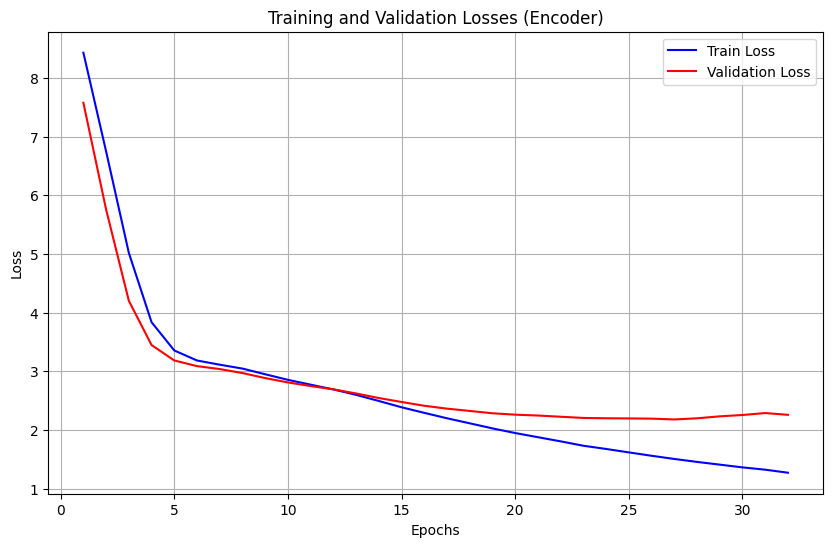

In [80]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_encoder) + 1), train_losses_encoder, label="Train Loss", color='b')
plt.plot(range(1, len(val_losses_encoder) + 1), val_losses_encoder, label="Validation Loss", color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (Encoder)')
plt.legend()
plt.grid(True)
plt.show()

Question 10: (1 Mark)

Plot the train and validation losses. Report the accuracy, precision and confusion matrix on all three dataset partitions.

Evaluation on Train Set (Encoder):
Accuracy: 0.5791
Precision: 0.5801


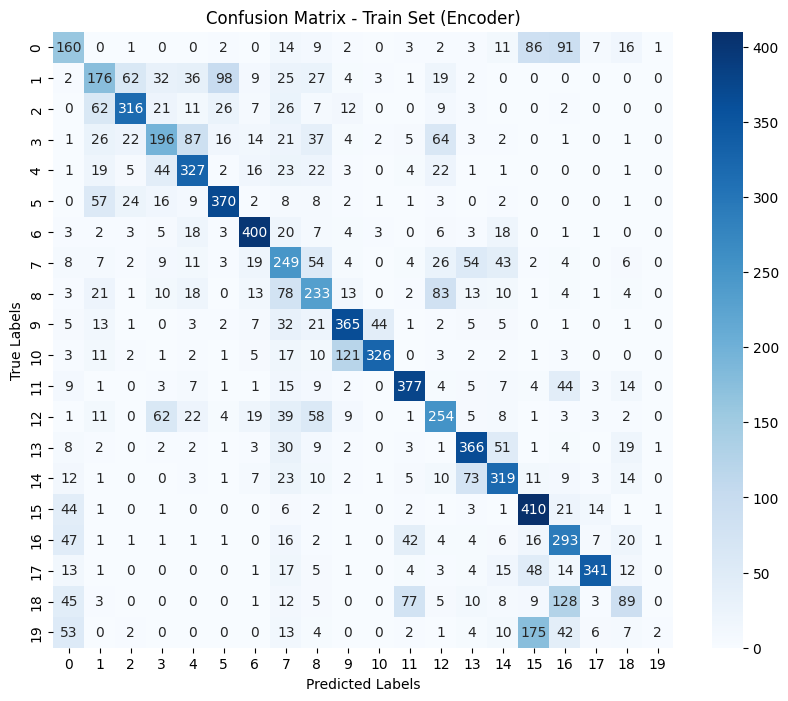

Evaluation on Validation Set (Encoder):
Accuracy: 0.3610
Precision: 0.3624


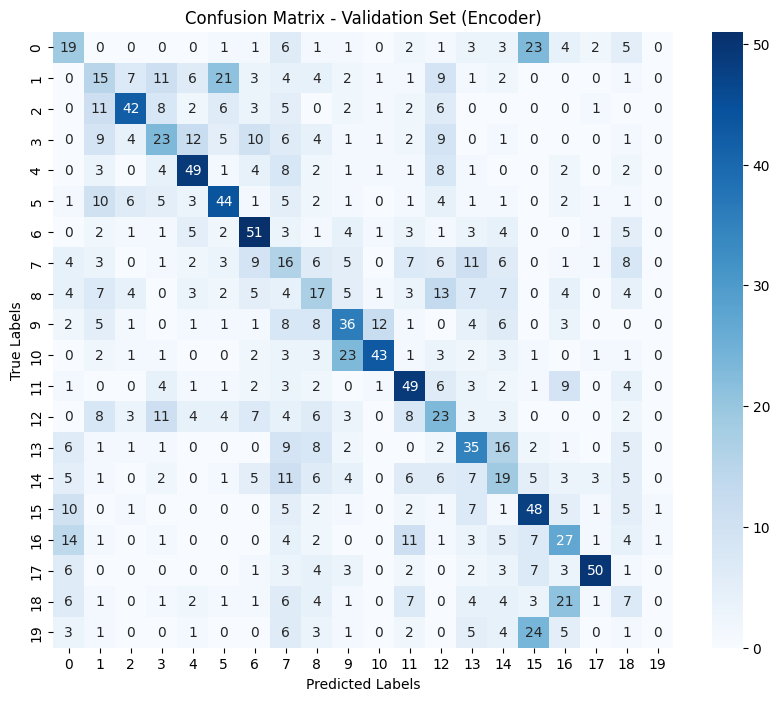

Evaluation on Test Set (Encoder):
Accuracy: 0.3486
Precision: 0.3686


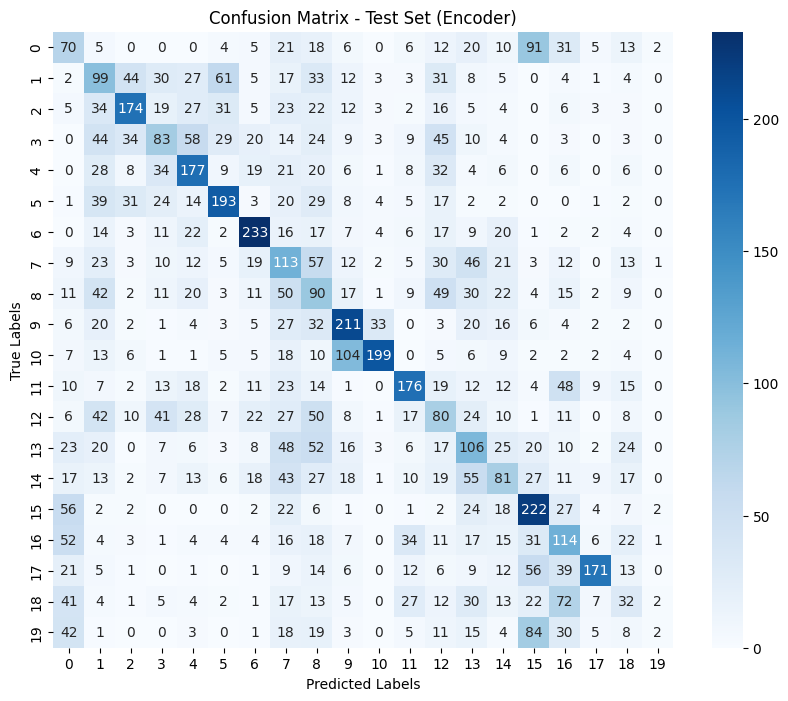

(0.34864577801380775,
 0.36857973149329937,
 array([[ 70,   5,   0,   0,   0,   4,   5,  21,  18,   6,   0,   6,  12,
          20,  10,  91,  31,   5,  13,   2],
        [  2,  99,  44,  30,  27,  61,   5,  17,  33,  12,   3,   3,  31,
           8,   5,   0,   4,   1,   4,   0],
        [  5,  34, 174,  19,  27,  31,   5,  23,  22,  12,   3,   2,  16,
           5,   4,   0,   6,   3,   3,   0],
        [  0,  44,  34,  83,  58,  29,  20,  14,  24,   9,   3,   9,  45,
          10,   4,   0,   3,   0,   3,   0],
        [  0,  28,   8,  34, 177,   9,  19,  21,  20,   6,   1,   8,  32,
           4,   6,   0,   6,   0,   6,   0],
        [  1,  39,  31,  24,  14, 193,   3,  20,  29,   8,   4,   5,  17,
           2,   2,   0,   0,   1,   2,   0],
        [  0,  14,   3,  11,  22,   2, 233,  16,  17,   7,   4,   6,  17,
           9,  20,   1,   2,   2,   4,   0],
        [  9,  23,   3,  10,  12,   5,  19, 113,  57,  12,   2,   5,  30,
          46,  21,   3,  12,   0,  13,   1],
    

In [81]:
best_encoder_model = TransformerClassifierEncoder(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_enc_layers=num_enc_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_len=max_len,
    dropout=dropout,
    device=device
).to(device)

best_encoder_model.load_state_dict(torch.load('best_encoder_model.pth'))
best_encoder_model.eval()

# Evaluate the encoder model
predict_and_evaluate(best_encoder_model, train_loader, "Train Set (Encoder)")
predict_and_evaluate(best_encoder_model, val_loader, "Validation Set (Encoder)")
predict_and_evaluate(best_encoder_model, test_loader, "Test Set (Encoder)")